# PRV Assignment 2

- Pablo Garcia Fernández

Initial configuration

In [7]:
# Initial configuration
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

#######################################
## PREDIFINE CONSTATNS OF THE EXERCISE
# Poner bien los valores -> ahora están aleatorios
camera_matrix = np.array([
    [123, 0, 400],
    [0, 123, 400],
    [0, 0, 1]
])
#######################################

### 1 - Obtain correspondence points from undistorted images 

In [2]:
def obtain_points(img1_n, img2_n, k=20000, no_matches=8, pintar=False):
    img1 = cv.imread(img1_n, cv.IMREAD_GRAYSCALE) 
    img2 = cv.imread(img2_n, cv.IMREAD_GRAYSCALE)

    sift = cv.SIFT_create(k)
    kp1, des1 = sift.detectAndCompute(img1, None) # q
    kp2, des2 = sift.detectAndCompute(img2, None) # t

    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = bf.match(des1, des2)
    print(f"Total no. matches: {len(matches)}")
    matches = (sorted(matches, key = lambda x:x.distance))[:no_matches]
    print(f"Keep no. matches: {len(matches)}")
    
    if pintar:
        img3 = cv.drawMatches(img1, kp1, img2, kp2, matches, img2, flags=2)
        plt.imshow(img3)
        plt.savefig(img1_n + img2_n + ".png", dpi=400)
        #plt.show()

    # Get points of the matches https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python
    # Each point -> (col, row)
    list_kp1 = [kp1[mat.queryIdx].pt for mat in matches] 
    list_kp2 = [kp2[mat.trainIdx].pt for mat in matches]
    
    return list_kp1, list_kp2

Total no. matches: 12355
Keep no. matches: 8


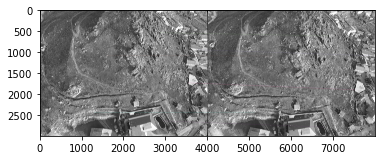

In [3]:
list_kp1, list_kp2 = obtain_points('DJI_0186.jpg', 'DJI_0187.jpg', pintar=True)

In [4]:
print(list_kp1)
print(list_kp2)

[(3550.252197265625, 1723.578125), (1606.626953125, 1081.4862060546875), (2936.12060546875, 2638.871337890625), (3549.142333984375, 1734.109375), (2878.027099609375, 538.8202514648438), (3780.427978515625, 945.3861083984375), (1293.89990234375, 2443.99658203125), (1486.731689453125, 2947.65673828125)]
[(3527.325927734375, 1889.9796142578125), (1544.174560546875, 1093.7490234375), (2771.706787109375, 2786.341552734375), (3525.247314453125, 1900.77001953125), (2903.38623046875, 615.8174438476562), (3882.265625, 1085.1976318359375), (1115.9364013671875, 2432.957763671875), (1241.10400390625, 2960.7412109375)]


### 2 - Relative orientation 

In [55]:
def relative_orientation(list_kp1, list_kp2, camera_matrix, img1_shape, img2_shape):
    camera_matrix_inverse = np.linalg.inv(camera_matrix)

    eq_matrix = []
    for p1, p2 in zip(list_kp1, list_kp2):
        # Convert tuple to array
        p1 = np.array(p1)
        p2 = np.array(p2)

        # Translate to w/2, h/2
        p1 = p1 + np.array([img1_shape[1]/2, img1_shape[0]/2])
        p2 = p2 + np.array([img2_shape[1]/2, img2_shape[0]/2])
        # Append c
        p1 = np.append(p1, camera_matrix[0,0]).reshape(-1,1)
        p2 = np.append(p2, camera_matrix[0,0]).reshape(-1,1)

        # Create ai
        ai = np.array([p2[0,0] * p1[0,0],
                    p2[0,0] * p1[1,0],
                    p2[0,0],
                    p2[1,0] * p1[0,0],
                    p2[1,0] * p1[1,0],
                    p2[1,0],
                    p1[0,0],
                    p1[1,0],
                    1 
        ])
        eq_matrix.append(ai)

    eq_matrix = np.array(eq_matrix)
    ## Solve the system of equations obtaining the SVD of the matrix
    u,d,vt = np.linalg.svd(eq_matrix)
    e_est = vt[:,-1].reshape((3,3))
    # Apply restrictions of the essential matrix: non-zero singular values are equal and the third is zero
    U,d,VT = np.linalg.svd(e_est)

    # Estos U, VT son directamente los U,Vt de la diapositiva 21

img1 = cv.imread('DJI_0186.jpg', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('DJI_0187.jpg', cv.IMREAD_GRAYSCALE)

relative_orientation(list_kp1, list_kp2, camera_matrix, img1.shape, img2.shape)




[[ 0.00186431 -0.00628931  0.99997848]
 [-0.00828439 -0.999946   -0.00627367]
 [-0.99996395  0.00827252  0.00191631]]
